In [1]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Libraries

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# Download the dataset

<a href="https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing"> Dataset </a>

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
from zipfile import ZipFile
with ZipFile('/content/gdrive/MyDrive/Kaggle Datasets/capuchinbird_calls_data.zip') as f:
    f.extractall(path = "/content/data")
f.close()

In [5]:
DATA_DIR = '/content/data'
CAPUCHIN_FILE = os.path.join(DATA_DIR, 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(DATA_DIR, 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [6]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

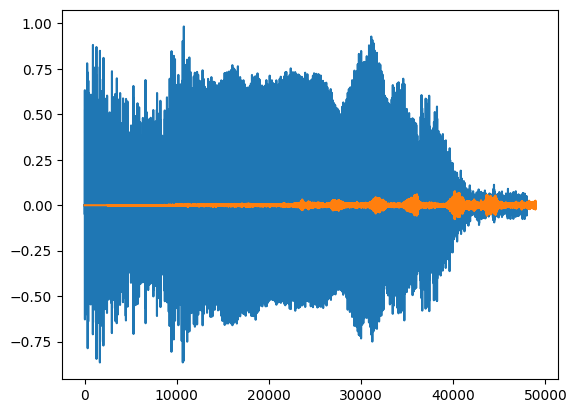

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Creating TF datasets

In [9]:
POS = os.path.join(DATA_DIR, 'Parsed_Capuchinbird_Clips')
NEG = os.path.join(DATA_DIR, 'Parsed_Not_Capuchinbird_Clips')

In [10]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [11]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# Determine Average Length of a Capuchin Call

In [12]:
lengths = []
for file in os.listdir(os.path.join(DATA_DIR, 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join(DATA_DIR, 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [13]:
mean, min, max = tf.math.reduce_mean(lengths), tf.math.reduce_min(lengths), tf.math.reduce_max(lengths)

In [14]:
mean

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [15]:
min

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [16]:
max

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

#Build Preprocessing Function to Convert to Spectrogram

In [17]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [18]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [19]:
spectrogram, label = preprocess(filepath, label)

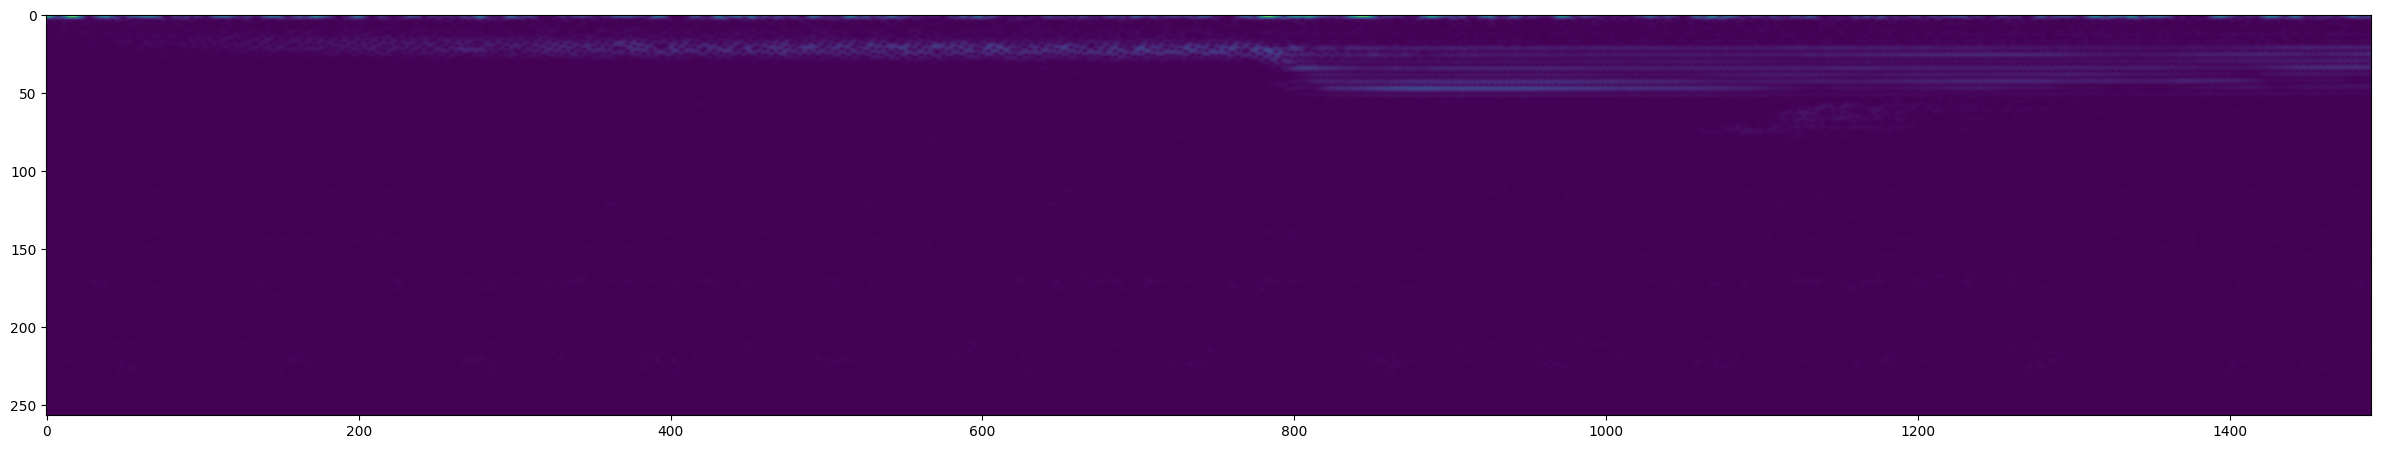

In [20]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Train/Test Split 

In [21]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [22]:
train = data.take(36)
test = data.skip(36).take(15)

In [23]:
samples, labels = train.as_numpy_iterator().next()

In [24]:
samples.shape

(16, 1491, 257, 1)

# Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

In [26]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPool2D((3,3)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPool2D((3,3)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [28]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 496, 85, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 494, 83, 16)       2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 164, 27, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 70848)             0         
                                                                 
 dense (Dense)               (None, 128)               9

In [29]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20
36/36 [==============================] - 8s 74ms/step - loss: 0.1926 - recall: 0.8535 - precision: 0.8993 - val_loss: 0.1478 - val_recall: 0.9828 - val_precision: 0.9344
Epoch 2/20
36/36 [==============================] - 2s 61ms/step - loss: 0.0835 - recall: 0.9312 - precision: 0.9803 - val_loss: 0.0325 - val_recall: 0.9865 - val_precision: 1.0000
Epoch 3/20
36/36 [==============================] - 2s 60ms/step - loss: 0.0243 - recall: 0.9870 - precision: 0.9935 - val_loss: 0.0054 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/20
36/36 [==============================] - 3s 70ms/step - loss: 0.0114 - recall: 0.9870 - precision: 1.0000 - val_loss: 0.0045 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/20
36/36 [==============================] - 2s 64ms/step - loss: 0.0133 - recall: 0.9932 - precision: 0.9932 - val_loss: 0.0017 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/20
36/36 [==============================] - 2s 61ms/step - loss: 0.0035 - recall: 1.000

In [30]:
hist.history.keys()

dict_keys(['loss', 'recall', 'precision', 'val_loss', 'val_recall', 'val_precision'])

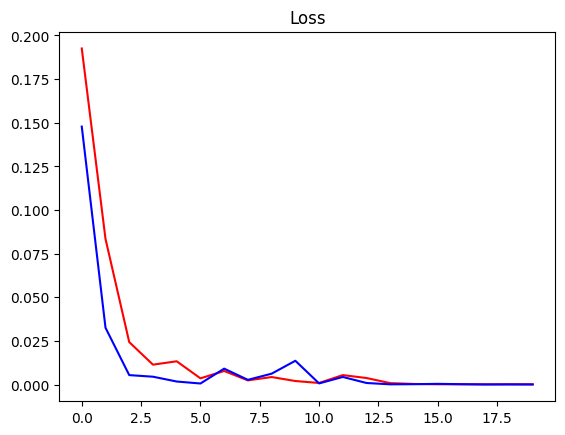

In [31]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

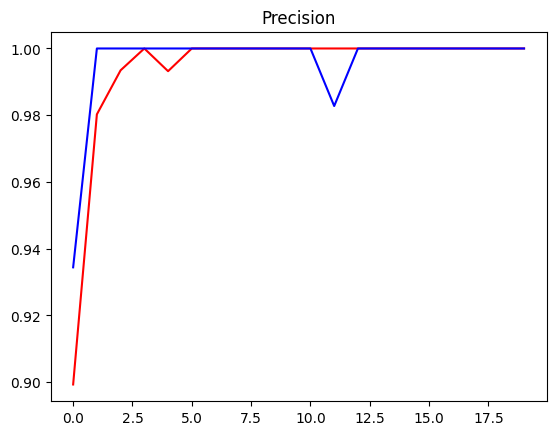

In [32]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

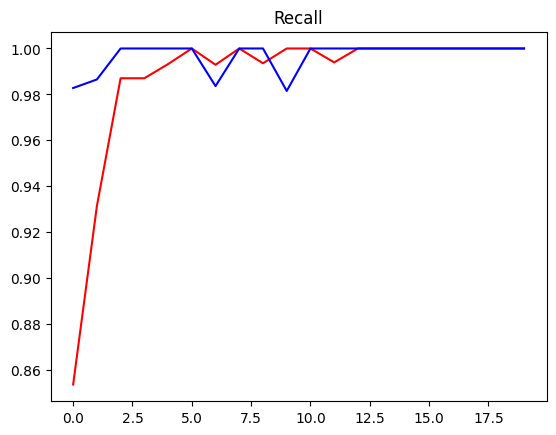

In [33]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# Making Prediciton on Single Audio Clip

In [34]:
X_test, y_test = test.as_numpy_iterator().next()

In [35]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 171ms/step


In [35]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [36]:
yhat

array([[1.2202791e-02],
       [1.0000000e+00],
       [1.7636716e-23],
       [2.8821283e-05],
       [0.0000000e+00],
       [1.2318989e-23],
       [2.5671377e-04],
       [4.2036085e-23],
       [4.3261372e-13],
       [8.3811055e-31],
       [6.2226678e-20],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [37]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [84]:
mp3 = os.path.join(DATA_DIR, 'Forest Recordings', 'recording_00.mp3')
mp3

'/content/data/Forest Recordings/recording_00.mp3'

In [85]:
wav = load_mp3_16k_mono(mp3)

In [86]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [87]:
samples, index = audio_slices.as_numpy_iterator().next()

##Function to Convert Clips into Windowed Spectrograms

In [88]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## Convert Longer Clips into Windows and Make Predictions

In [90]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [91]:
confidence = 0.1
yhat = model.predict(audio_slices)
yhat = [1 if prediction > confidence else 0 for prediction in yhat]

1/1 [==============================] - 1s 1s/step


In [95]:
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
calls

5

# Making Predictions on entire Forest Recording Data

## Loop over to Recordings Folder and Make Predicitions

In [96]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 1s 1s/step


In [99]:
results

{'recording_27.mp3': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 'recording_34.mp3': array([[1.4300369e-04],
        [1.0000000e+00],
        [1.9963721e-08],
        [2.1973459e-08],
   

# Convert Predictions into Classes

In [98]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > confidence else 0 for prediction in logits]
class_preds

{'recording_27.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_34.mp3': [0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_91.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_52.mp3': [0,
  0,
  0,
  

 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

In [52]:
import csv

In [53]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [54]:
import pandas as pd

In [55]:
df = pd.read_csv('./results.csv')

In [60]:
df.head(10)

,recording,capuchin_calls
0,recording_27.mp3,0
1,recording_34.mp3,4
2,recording_91.mp3,0
3,recording_52.mp3,0
4,recording_85.mp3,0
5,recording_09.mp3,0
6,recording_61.mp3,11
7,recording_70.mp3,4
8,recording_15.mp3,2
9,recording_89.mp3,4


In [57]:
df.tail(10)

,recording,capuchin_calls
90,recording_33.mp3,0
91,recording_07.mp3,2
92,recording_00.mp3,5
93,recording_58.mp3,0
94,recording_39.mp3,11
95,recording_24.mp3,0
96,recording_79.mp3,0
97,recording_68.mp3,1
98,recording_66.mp3,0
99,recording_94.mp3,3
